In [81]:
#import Libraries
import numpy as np

from tqdm import tqdm
import cv2
import os
from random import shuffle

In [94]:
#data import

trn_mal_path = r"D:\College\Semester 5\Breadth - application of Machine learning in biological systems\Assignments\Post mid-sem\Project 2\Dataset2\FNA\malignant" #malignant cases
trn_ben_path = r"D:\College\Semester 5\Breadth - application of Machine learning in biological systems\Assignments\Post mid-sem\Project 2\Dataset2\FNA\benign" #benign cases
pred_path = r"D:\College\Semester 5\Breadth - application of Machine learning in biological systems\Assignments\Post mid-sem\Project 2\Dataset2\test" #images to be predict

trn = []
pred = []

IMG_SIZE = 50

#Benign cases
for img in tqdm(os.listdir(trn_ben_path)):
    path = os.path.join(trn_ben_path, img)
    img_ben = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    trn.append([np.array(img_ben), np.array([0,1])])


#malingant cases
for img in tqdm(os.listdir(trn_mal_path)):
    path = os.path.join(trn_mal_path, img)
    img_mal = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    trn.append([np.array(img_mal), np.array([1,0])])

shuffle(trn)


#Prediction cases
for img in tqdm(os.listdir(pred_path)):
    path = os.path.join(pred_path, img)
    img_num = img.split('.')[0]
    img_pred = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    pred.append([np.array(img_pred),img_num])


# Splitting the testing data and training data
train = trn[:-500]
test = trn[-500:]

#training st
train_X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
train_Y = np.array([i[1] for i in train])

#validation set
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = np.array([i[1] for i in test])

#to predict
pred_x = np.array([i[0] for i in pred]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)



#Model building
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

MODEL_NAME = 'BC-{}-{}.model'.format(LR, '6conv-basic')
import tensorflow as tf

LR = 1e-3   #learning rate


tflearn.init_graph(num_cores=1, gpu_memory_fraction=1.0) # num_cores=8, gpu_memory_fraction=0.5

accuracy = [ ]
loss = [ ]

#Storing accuracy/loss
class MonitorCallback(tflearn.callbacks.Callback):
    def __init__(self, api):
        self.my_monitor_api = api

#def on_batch_end(training_state, snapshot, log={}):    
    def on_sub_batch_end(self, training_state, train_index=0):
        try:
            accuracy.append( str(training_state.acc_value) )
            loss.append( str(training_state.loss_value) )
        except Exception as e:
            print(str(e))

monitorCallback = MonitorCallback(tflearn)


tf.compat.v1.reset_default_graph()
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input')

convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation ='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation ='softmax')
convnet = regression(convnet, optimizer ='adam', learning_rate = LR,
      loss ='categorical_crossentropy', name ='targets')

model = tflearn.DNN(convnet, tensorboard_dir ='log')
model.fit({'input': train_X}, {'targets': train_Y}, n_epoch = 20, 
    validation_set =({'input': test_x}, {'targets': test_y}), 
    snapshot_step = 2, show_metric = True, run_id = MODEL_NAME, callbacks=monitorCallback)
model.save(MODEL_NAME)

Training Step: 399  | total loss: 0.23257 | time: 10.238s
| Adam | epoch: 020 | loss: 0.23257 - acc: 0.9216 -- iter: 1216/1224
Training Step: 400  | total loss: 0.25078 | time: 11.315s
| Adam | epoch: 020 | loss: 0.25078 - acc: 0.9169 | val_loss: 0.43624 - val_acc: 0.8240 -- iter: 1224/1224
--
INFO:tensorflow:d:\College\Semester 5\Breadth - application of Machine learning in biological systems\Assignments\Post mid-sem\Project 2\BC-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


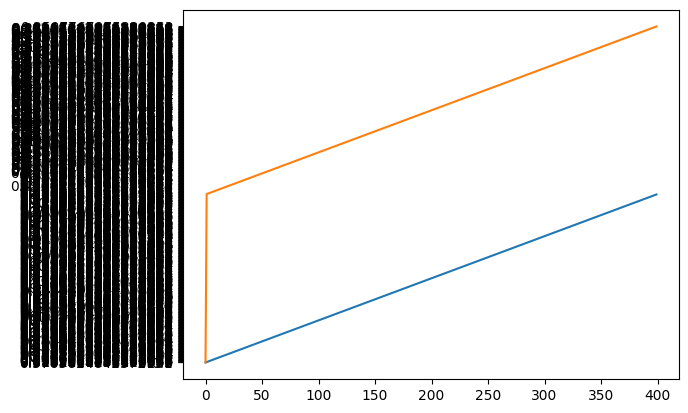

In [96]:
#Accuracy/loss
plt.plot( accuracy )
plt.plot( loss )
plt.show()
plt.close()

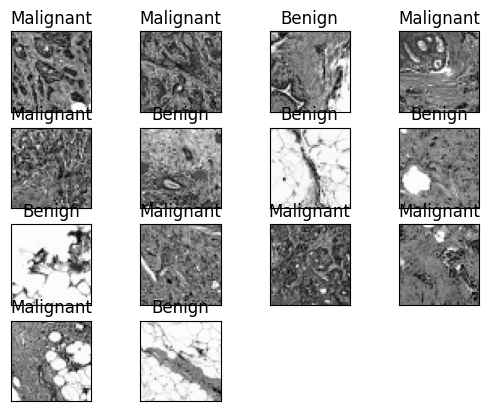

In [95]:
#Predict

import matplotlib.pyplot as plt

fig = plt.figure()

for num,data in enumerate(pred_x):
     
    img_data = pred_x[num]
     
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
     
    if np.argmax(model_out) == 1: str_label ='Benign'
    else: str_label ='Malignant'
         
    y.imshow(orig, cmap ='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()